In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
from gpytorch import means, kernels
import tqdm
import importlib

base_dir = os.path.join(os.getcwd(), '../../')
sys.path.append(base_dir)

from src.kernels import CMEAggregateKernel
from src.means import CMEAggregateMean
from src.models import ExactCMEProcess

## Simulation Data

Let $Y\sim\mathcal{U}[-2\pi, 2\pi]$, then if we define $X = r(Y)$ and $Z = f(X)$, we suppose that $Z$ is unobserved but we rather observe

$$
\bar Z|\{Y=y\} = \mathbb{E}[Z|Y=y] + \varepsilon = f(r(y)) + \varepsilon
$$

Then we can use CME process formulation to infer $f$ out of observations of $X, Y, \bar Z|Y$.

This is obviously an overkill, we could have solved GP regression task of $X$ onto $\bar Z|Y$.

In [7]:
r = lambda x: 2 * np.pi * torch.cos(x)
f = lambda x: x * torch.sin(x)

n = 100
noise_std = 0.025
y = 4 * np.pi * torch.rand(n) - 2 * np.pi
x = r(y)
z = f(x)
observed_aggregate_z = f(r(y)) + noise_std * torch.randn_like(y)

bags_sizes = [1] * len(y)

## Define CME Process Model

In [8]:
individuals_mean = means.ZeroMean()
individuals_kernel = kernels.RBFKernel()
bag_kernel = kernels.RBFKernel()

model = ExactCMEProcess(individuals_mean=individuals_mean, 
                        individuals_kernel=individuals_kernel,
                        bag_kernel=bag_kernel,
                        train_individuals=x,
                        train_bags=y,
                        train_aggregate_targets=observed_aggregate_z,
                        bags_sizes=bags_sizes,
                        lbda=1e-3,
                        likelihood=gpytorch.likelihoods.GaussianLikelihood())

## MLE estimate of hyperparameters

In [9]:
model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

epochs = 20

epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for i in epoch_iter:
    optimizer.zero_grad()
    output = model(y)
    loss = -mll(output, z)
    mvn = model.likelihood(model(y))
    loss = mvn.log_prob(z).div(-len(z))
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.update_cme_estimate_parameters()
    epoch_iter.set_postfix(loss=loss.item())

print("Final Marginal Likelihood : ", torch.exp(-loss).item())


Final Marginal Likelihood :  0.36800768971443176


## Predict

In [10]:
model.eval()
model.likelihood.eval()

with torch.no_grad():
    y_test = torch.linspace(-2 * np.pi , 2 * np.pi , 200)
    observed_pred = model.likelihood(model(y_test))
    individuals_posterior = model.predict(x)

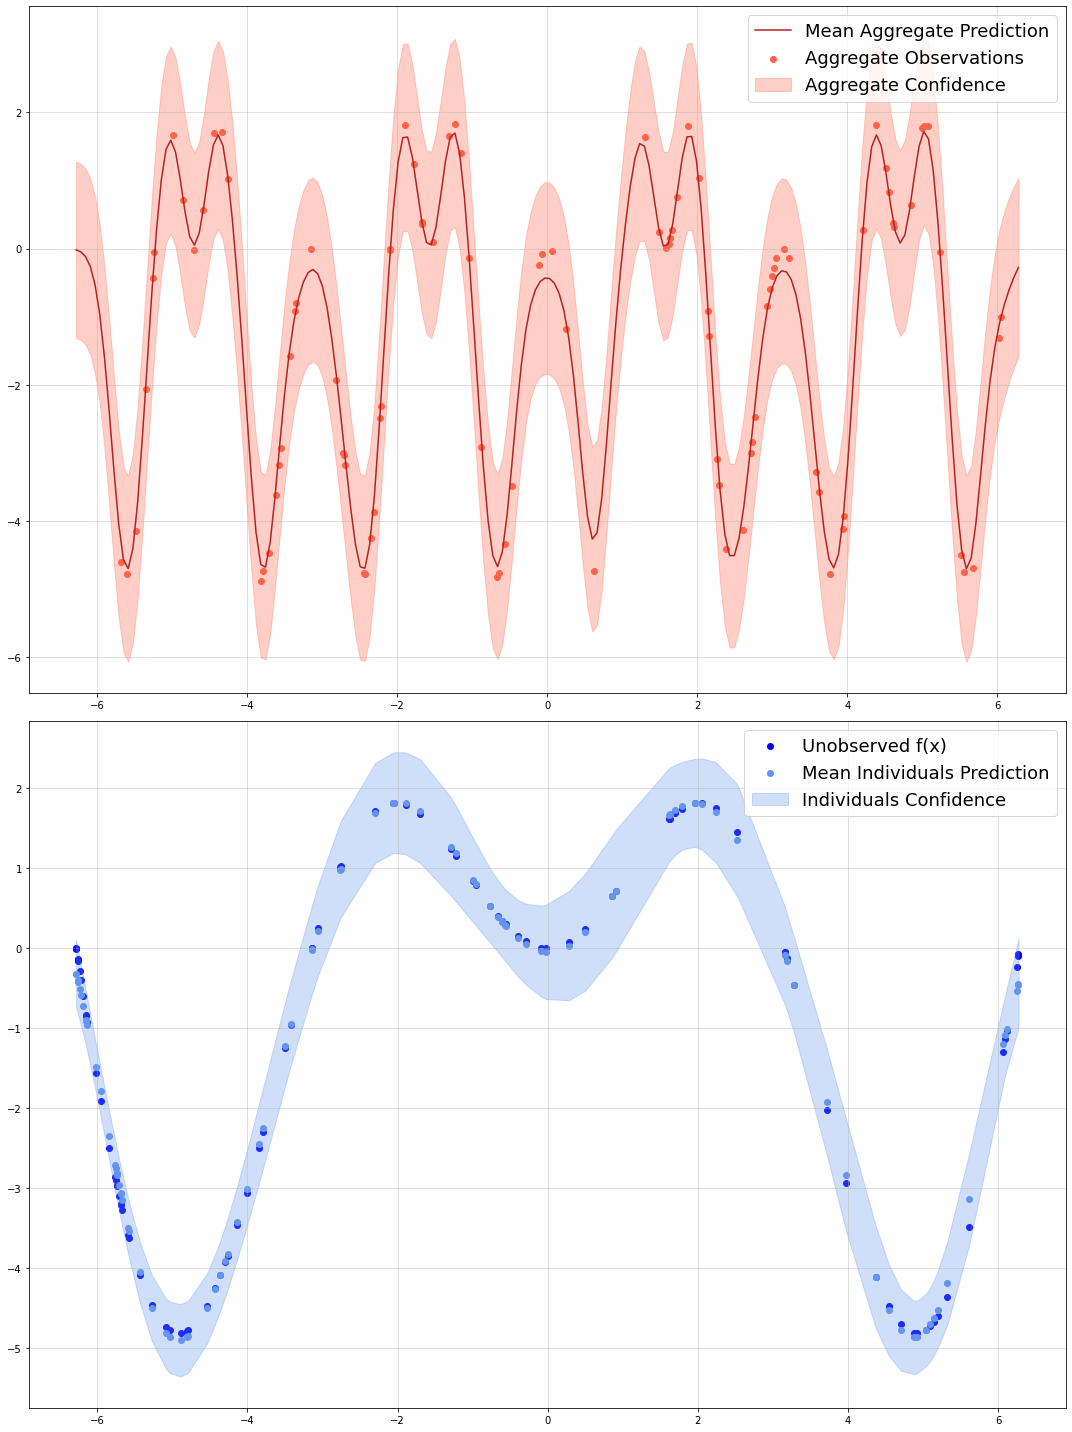

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(15, 20))
lower, upper = observed_pred.confidence_region()
ax[0].scatter(y, observed_aggregate_z, color='tomato', label='Aggregate Observations')
ax[0].plot(y_test, observed_pred.mean, 'firebrick', label='Mean Aggregate Prediction')
ax[0].fill_between(x=y_test, y1=lower.numpy(), y2=upper.numpy(), color='tomato', alpha=0.3, label='Aggregate Confidence')

lower, upper = individuals_posterior.confidence_region()
lower, upper = lower.detach(), upper.detach()

sorted_idx = np.argsort(x.numpy())
sorted_x = x[sorted_idx]
lower, upper = lower[sorted_idx], upper[sorted_idx]
# ax.plot(x, f(x), '--', linewidth=1, color='blue', label=r'$f(x)$')
ax[1].scatter(x, z, color='blue', label='Unobserved f(x)')
# ax.plot(x, individuals_posterior.mean.detach(), 'blue', label='Mean Individuals Prediction')
ax[1].scatter(x, individuals_posterior.mean.detach(), color='cornflowerblue', label='Mean Individuals Prediction')
ax[1].fill_between(x=sorted_x, y1=lower.numpy(), y2=upper.numpy(), color='cornflowerblue', alpha=0.3, label='Individuals Confidence')

ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[0].legend(fontsize=18)
ax[1].legend(fontsize=18)
plt.tight_layout()
plt.show()